Package setting

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import skfmm

from torch.utils.data import TensorDataset, DataLoader
from utils import *
from model import *
from train import *

set_seed(10)
device = set_device()

Cuda installed! Running on GPU!
Device: cuda:0 NVIDIA GeForce GTX 1650


Network Parameters

In [2]:
# Network
act = 'ELU'
lay = 'linear'
unit = 30 # number of units for each layer
hidden = 10 # number of hidden layers

# Optimizer
opttype = 'adam'
lr = 1e-4
epochs = 10000
perc = 0.25
randompoints = True
batch_size = 256

# Weights
lambda_pde, lambda_init = 1., 10.

Geometry and initial traveltime

In [3]:
# Model grid (km)
ox, dx, nx = 0., 20./1000., 101 
oz, dz, nz = 0., 20./1000., 101 

# Velocity model (km/s)
v0 = 2000./1000.
k_vertical = 0.5; # Vertical gradient
k_horizontal = 0.; # Horizontal gradient

# Point-Source Location (km)
xs, zs = 1000./1000., 1000./1000.


# Computational domain
x, z, X, Z = eikonal_grid(ox, dx, nx, oz, dz, nz)

# initial velocity model
vel = v0 + k_vertical * (Z - oz) + k_horizontal * (X - ox)
isource = (X == xs) & (Z == zs)
vsource = vel[isource]

# Analytical solution
if k_vertical == 0. and k_horizontal == 0.:
    # Constant velocity
    t0, t0_dx, t0_dz = eikonal_constant(ox, dx, nx, oz, dz, nz, xs, zs, vsource)
else:
    # Variable velocity
    t0, t0_dx, t0_dz = eikonal_constant(ox, dx, nx, oz, dz, nz, xs, zs, vsource)
    tana = eikonal_gradient(ox, dx, nx, oz, dz, nz, xs, zs, v0, k_vertical, k_horizontal)

# Eikonal solution
teik = eikonal_fmm(ox, dx, nx, oz, dz, nz, xs, zs, vel)

# Factorized eikonal solution: t= tau * t0
tauana = tana / t0
tauana[np.isnan(tauana)] = 1.

d:\pythonProject\PINN_Eikonal_Pytorch\code\utils.py:55: RuntimeWarning: invalid value encountered in divide
  tana_dx = (X - xs) / (dana * v)
d:\pythonProject\PINN_Eikonal_Pytorch\code\utils.py:56: RuntimeWarning: invalid value encountered in divide
  tana_dz = (Z - zs) / (dana * v)
C:\Users\86183\AppData\Local\Temp\ipykernel_13300\3077611912.py:35: RuntimeWarning: invalid value encountered in divide
  tauana = tana / t0


Training network

In [4]:
# Remove source from grid of points to be used in training
X_nosrc, Z_nosrc, v_nosrc, t0_nosrc, t0_dx_nosrc, t0_dz_nosrc = \
    remove_source(X, Z, xs, zs, vel, t0, t0_dx, t0_dz)

# Create evaluation grid
grid_loader = create_gridloader(X, Z, device=device)

# Define and initialize network
model1 = Network(2, 1, [unit]*hidden, act=act, lay=lay)
model1.to(device)
#print(model1)

# Optimizer
if opttype == 'adam':
    optimizer1 = torch.optim.Adam(model1.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-5)
elif opttype == 'lbfgs':
    optimizer1 = torch.optim.LBFGS(model1.parameters(), line_search_fn="strong_wolfe")

# Create dataloader for training
# data_loader, ic_loader = create_dataloader(X_nosrc, Z_nosrc, xs, zs, t0_nosrc, t0_dx_nosrc, t0_dz_nosrc,
#                                             batch_size=batch_size, perc=perc, device=device)

tau_history = []
loss_pde_history = []
loss_ic_history = []
loss_history = []

for i in range(epochs):
    data_loader, ic_loader = create_dataloader(X_nosrc, Z_nosrc, xs, zs, v_nosrc, t0_nosrc, t0_dx_nosrc, t0_dz_nosrc,
                                            batch_size=batch_size, perc=perc, device=device)
    if i == 0:
        print('Recreate dataloader...')
        print('Number of points used per epoch:%d' % int(perc * len(X)))

        # Train step
    loss, loss_pde, loss_ic = train(model1, optimizer1, data_loader, ic_loader,
                                        lossweights=(lambda_pde, lambda_init), vscaler=1, 
                                        device=device)
    loss_pde_history.append(loss_pde)
    loss_ic_history.append(loss_ic)
    loss_history.append(loss)

        # Store train loss in wandb logger
    try:
        wandb.log({"train_loss": loss})
    except:
        pass

    if i % 100 == 0:
            # Evaluate grid
        tau_history.append(evaluate(model1, grid_loader, device=device))
        print(f'Epoch {i}, Loss {loss:.7f}')

Recreate dataloader...
Number of points used per epoch:25


C:\Users\86183\AppData\Roaming\Python\Python313\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0, Loss 13.5354439
Epoch 100, Loss 0.0028077
Epoch 200, Loss 0.0014724
Epoch 300, Loss 0.0002900
Epoch 400, Loss 0.0000855
Epoch 500, Loss 0.0000497
Epoch 600, Loss 0.0000310
Epoch 700, Loss 0.0000201
Epoch 800, Loss 0.0000158
Epoch 900, Loss 0.0000120
Epoch 1000, Loss 0.0000078
Epoch 1100, Loss 0.0000097
Epoch 1200, Loss 0.0000087
Epoch 1300, Loss 0.0000049
Epoch 1400, Loss 0.0000043
Epoch 1500, Loss 0.0000043
Epoch 1600, Loss 0.0000039
Epoch 1700, Loss 0.0000034
Epoch 1800, Loss 0.0000031
Epoch 1900, Loss 0.0000054
Epoch 2000, Loss 0.0000048
Epoch 2100, Loss 0.0000028
Epoch 2200, Loss 0.0000025
Epoch 2300, Loss 0.0000020
Epoch 2400, Loss 0.0000019
Epoch 2500, Loss 0.0000044
Epoch 2600, Loss 0.0000015
Epoch 2700, Loss 0.0000041
Epoch 2800, Loss 0.0000025
Epoch 2900, Loss 0.0000010
Epoch 3000, Loss 0.0000009
Epoch 3100, Loss 0.0000008
Epoch 3200, Loss 0.0000101
Epoch 3300, Loss 0.0000007
Epoch 3400, Loss 0.0000036
Epoch 3500, Loss 0.0000006
Epoch 3600, Loss 0.0000007
Epoch 3700, 

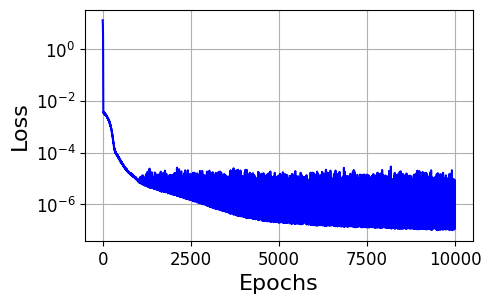

In [5]:
# Convergence history plot for verification

fig = plt.figure(figsize=(5,3))
ax = plt.axes()
ax.semilogy(loss_history,'b')

ax.set_xlabel('Epochs',fontsize=16)

plt.xticks(fontsize=12)
ax.xaxis.set_major_locator(plt.MultipleLocator(2500))

ax.set_ylabel('Loss',fontsize=16)
plt.yticks(fontsize=12);
plt.grid()

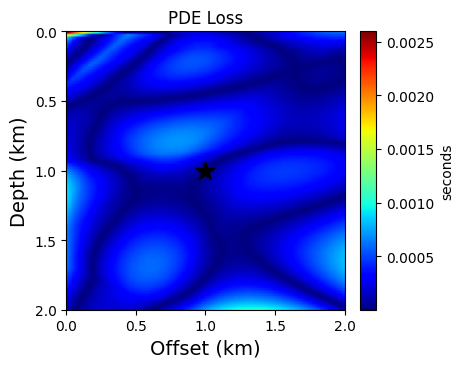

In [6]:
# Compute PDE loss
pde_loader, _ = create_dataloader(X.ravel(), Z.ravel(), xs, zs, vel.ravel(), t0.ravel(), t0_dx.ravel(), t0_dz.ravel(), 
                                  perc=1., shuffle=False, device=device)

pde, vpred = evaluate_pde(model1, pde_loader, device=device)

from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.style.use('default')

plt.figure(figsize=(4, 4))

ax = plt.gca()
im = ax.imshow(np.abs(pde.detach().cpu().numpy().reshape(nz, nx)),
                extent=(x[0], x[-1], z[-1], z[0]), cmap='jet')
plt.scatter(xs, zs, s=200, marker='*', color='k')

plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

plt.title('PDE Loss')

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds',size=10)
cbar.ax.tick_params(labelsize=10)

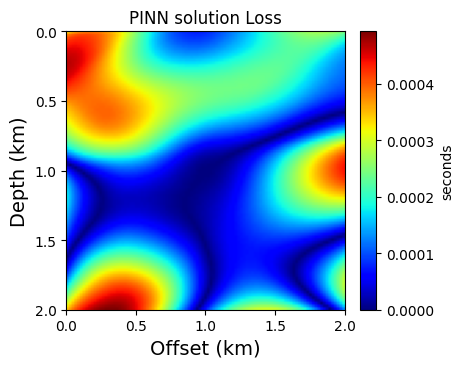

In [7]:
# Plot the PINN solution error

tau_pred = evaluate(model1, grid_loader, device='cuda')

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(np.abs(tau_pred.detach().cpu().numpy().reshape(nz, nx)*t0-tana), extent=[x.min(),x.max(),z.max(),z.min()], aspect=1, cmap="jet")


plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

plt.title('PINN solution Loss')

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds',size=10)
cbar.ax.tick_params(labelsize=10)

#plt.savefig("./figs/vofz/pinnerror.pdf", format='pdf', bbox_inches="tight")

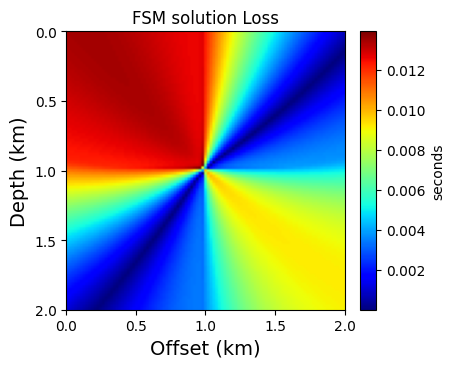

In [8]:
# Plot the first order FSM solution error

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(np.abs(teik-tana), extent=[x.min(),x.max(),z.max(),z.min()], aspect=1, cmap="jet")


plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

plt.title('FSM solution Loss')

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds',size=10)

cbar.ax.tick_params(labelsize=10)

#plt.savefig("./figs/vofz/fsmerror.pdf", format='pdf', bbox_inches="tight")

(array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 [Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0'),
  Text(0, 2.5, '2.5')])

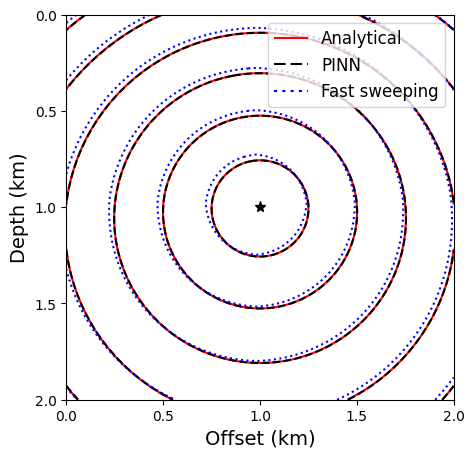

In [9]:
# Traveltime contour plots

plt.figure(figsize=(5,5))

ax = plt.gca()
im1 = ax.contour(tana, 6, extent=[x.min(),x.max(),z.min(),z.max()], colors='r')
im2 = ax.contour(tau_pred.detach().cpu().numpy().reshape(nz, nx)*t0, 6, extent=[x.min(),x.max(),z.min(),z.max()], colors='k',linestyles = 'dashed')
im3 = ax.contour(teik, 6, extent=[x.min(),x.max(),z.min(),z.max()], colors='b',linestyles = 'dotted')

ax.plot(xs, zs,'k*',markersize=8)
ax.invert_yaxis()
plt.xlabel('Offset (km)', fontsize=14)
plt.ylabel('Depth (km)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=8)
#plt.gca().invert_yaxis()
h1,_ = im1.legend_elements()
h2,_ = im2.legend_elements()
h3,_ = im3.legend_elements()
ax.legend([h1[0], h2[0],h3[0]], ['Analytical', 'PINN', 'Fast sweeping'],fontsize=12)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)



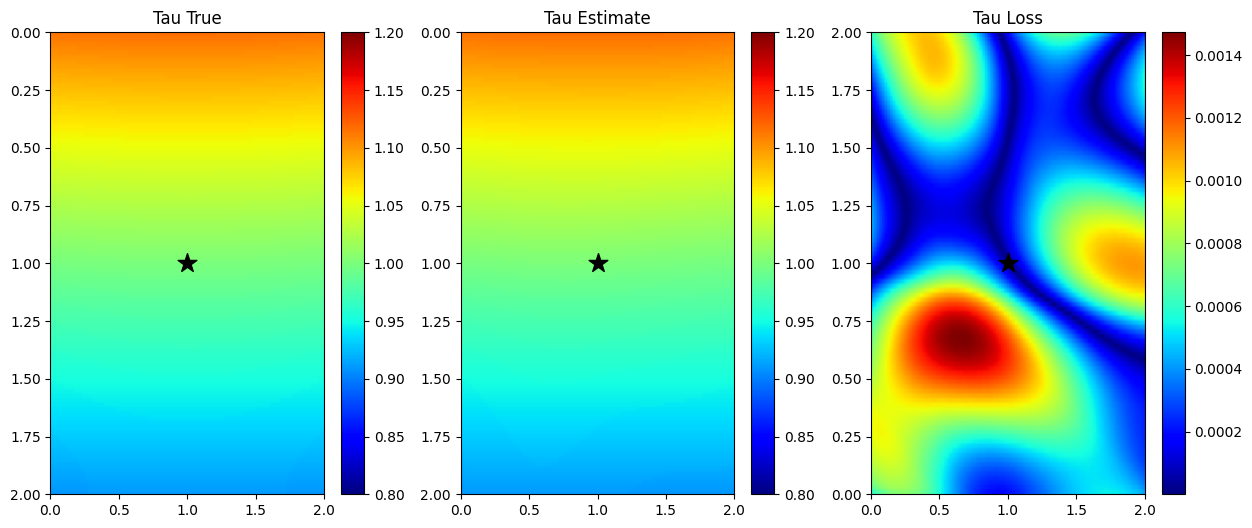

In [10]:
# Compute traveltime with trained network 
tau_est = evaluate(model1, grid_loader, device=device)

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
im = axs[0].imshow(tauana, vmin=0.8, vmax=1.2,
                   extent=(x[0], x[-1], z[-1], z[0]), cmap='jet')
axs[0].scatter(xs, zs, s=200, marker='*', color='k')
axs[0].set_title('Tau True')
axs[0].axis('tight')
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(tau_est.detach().cpu().numpy().reshape(nz, nx), vmin=0.8, vmax=1.2,
                   extent=(x[0], x[-1], z[-1], z[0]), cmap='jet')
axs[1].scatter(xs, zs, s=200, marker='*', color='k')
axs[1].set_title('Tau Estimate')
axs[1].axis('tight')
plt.colorbar(im, ax=axs[1])

im = axs[2].imshow(np.abs(tau_est.detach().cpu().numpy().reshape(nz, nx)-tauana), extent=(x[0], x[-1], z[-1], z[0]), cmap='jet')
axs[2].scatter(xs, zs, s=200, marker='*', color='k')
axs[2].set_title('Tau Loss')
axs[2].axis('tight')
axs[2].invert_yaxis()
plt.colorbar(im, ax=axs[2]);

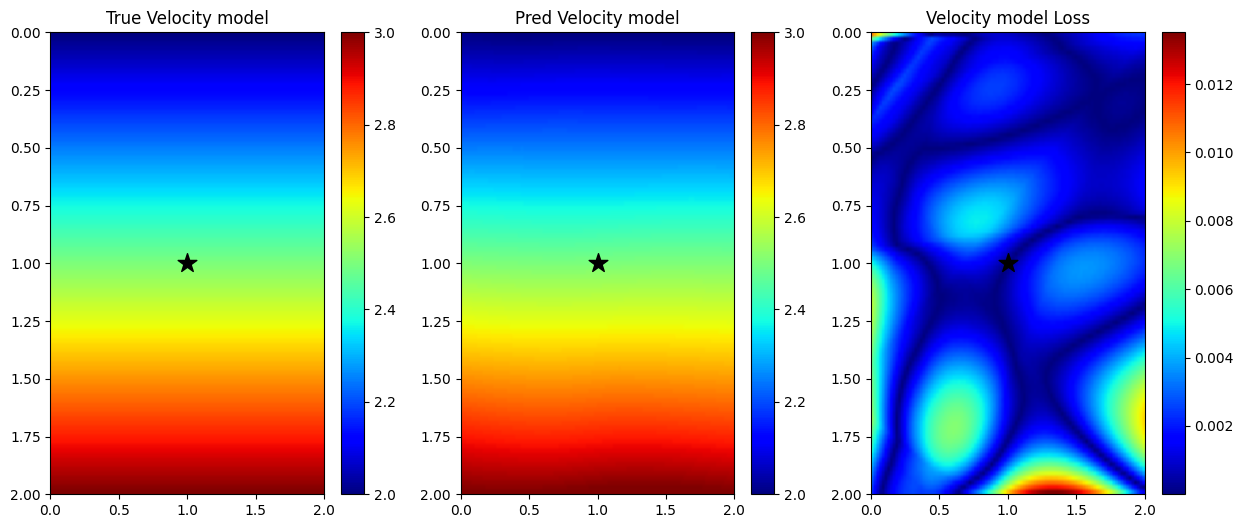

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
a=axs[0].imshow(vel, extent=(x[0], x[-1], z[-1], z[0]), vmin=vel.min(), vmax=vel.max(),
              cmap='jet')
axs[0].scatter(xs, zs, s=200, marker='*', color='k')
axs[0].set_title('True Velocity model')
axs[0].axis('tight')
plt.colorbar(a);

b=axs[1].imshow(vpred.detach().cpu().numpy().reshape(nz, nx), 
              extent=(x[0], x[-1], z[-1], z[0]), vmin=vel.min(), vmax=vel.max(),
              cmap='jet')
axs[1].scatter(xs, zs, s=200, marker='*', color='k')
axs[1].set_title('Pred Velocity model')
axs[1].axis('tight')
plt.colorbar(b);

c=axs[2].imshow(np.abs(vpred.detach().cpu().numpy().reshape(nz, nx)-vel), 
              extent=(x[0], x[-1], z[-1], z[0]), cmap='jet')
axs[2].scatter(xs, zs, s=200, marker='*', color='k')
axs[2].set_title('Velocity model Loss')
axs[2].axis('tight')
plt.colorbar(c);